_Stefano Maxenti - maxenti.s@northeastern.edu_

# EECE 7398: Verifiable Machine Learning -- Fall 2023
# Exercise #1: Adversarial Examples & Decision Boundaries

**Submission Instructions:** Please upload a .ipynb file (including your code, plots, and written answers) to Gradescope. This file can be updated unlimited times until the submission deadline.
TA Email Bishoy Galoaa. galoaa.b@northeastern.edu

# Problem 1: Train & Attack an MNIST Classifier

## 1a) Train an MNIST Classifier

To start, train a NN classifier that consists of:
- a "Flatten" layer to convert the (28, 28) images to (784,)
- a fully connected layer with 128 neurons and ReLU activation
- a fully connected (output) layer with 10 neurons (10 neurons for 10 digit categories)
- (optionally) a softmax layer to convert logits to probabilities

You can use the Adam optimizer with cross entropy loss (make sure to use the correct loss depending on whether you included a softmax layer) and it should work pretty well.

**Deliverables**:
- Plot your train and validation loss curves as a function of epoch
- From a test set, provide some examples where your classifier predicted correctly & incorrectly (if applicable)

I start by importing the needed libraries for Tensorflow.

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

/Users/stefanomaxenti/.pyenv/versions/3.9.13/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


As requested, I create the model. I use a small learning rate (0.0001) instead of the default one (0.001) so that it is easier to show the loss over the number of epochs.

In [2]:
def create_model():
    model = tf.keras.Sequential()

    model.add(tf.keras.layers.Flatten(input_shape=(28, 28)))
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dense(10, activation='relu'))
    model.add(tf.keras.layers.Dense(10, activation='softmax'))
    loss = tf.keras.losses.CategoricalCrossentropy()
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    
    metrics = ['accuracy']

    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    return model

In [3]:
model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 128)               100480    
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
 dense_2 (Dense)             (None, 10)                110       
                                                                 
Total params: 101,880
Trainable params: 101,880
Non-trainable params: 0
_________________________________________________________________


I load the MNIST dataset, I split into training and test, and I one-hot encode the labels.

In [3]:
mnist = tf.keras.datasets.mnist
(x_train_orig, y_train_orig), (x_test_orig, y_test_orig) = mnist.load_data()
y_train = tf.one_hot(y_train_orig.astype(np.int32), depth=10)
y_test = tf.one_hot(y_test_orig.astype(np.int32), depth=10)

Let's apply MinMax normalization. I keep the max and min from the training set since I don't want to leak any information to reduce overfitting.

In [4]:
max_train = x_train_orig.max()
min_train = x_train_orig.min()

x_train = (x_train_orig - min_train)/(max_train - min_train)
x_test = (x_test_orig - min_train)/(max_train - min_train)

I train the model, using a 15% validation set. I include a basic early stopping callback to reduce overfitting monitoring the validation loss.

In [6]:
history = model.fit(x_train, y_train, validation_split = 0.85, epochs=150, callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, verbose=1))

Epoch 1/150


2023-09-14 23:24:21.468765: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


282/282 [==============================] - 1s 4ms/step - loss: 1.9422 - accuracy: 0.2628 - val_loss: 1.5794 - val_accuracy: 0.4796
Epoch 2/150
282/282 [==============================] - 1s 3ms/step - loss: 1.2294 - accuracy: 0.6777 - val_loss: 1.0049 - val_accuracy: 0.7553
Epoch 3/150
282/282 [==============================] - 1s 3ms/step - loss: 0.8227 - accuracy: 0.8064 - val_loss: 0.7397 - val_accuracy: 0.8128
Epoch 4/150
282/282 [==============================] - 1s 3ms/step - loss: 0.6242 - accuracy: 0.8499 - val_loss: 0.5982 - val_accuracy: 0.8478
Epoch 5/150
282/282 [==============================] - 1s 3ms/step - loss: 0.5135 - accuracy: 0.8738 - val_loss: 0.5138 - val_accuracy: 0.8691
Epoch 6/150
282/282 [==============================] - 1s 3ms/step - loss: 0.4416 - accuracy: 0.8916 - val_loss: 0.4620 - val_accuracy: 0.8803
Epoch 7/150
282/282 [==============================] - 1s 3ms/step - loss: 0.3931 - accuracy: 0.9024 - val_loss: 0.4224 - val_accuracy: 0.8881
Epoch 8/150

Let's plot both loss and accuracy over the training data and the validation data.

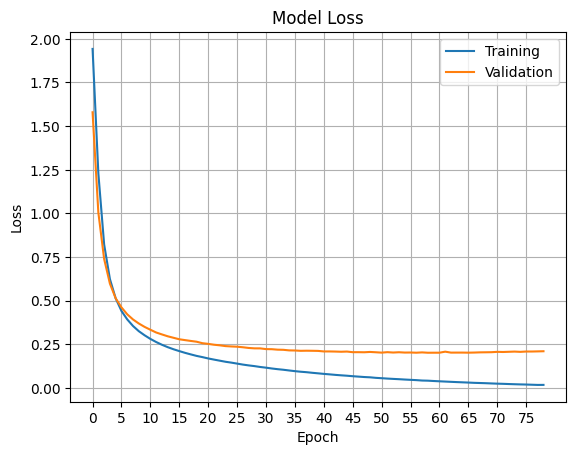

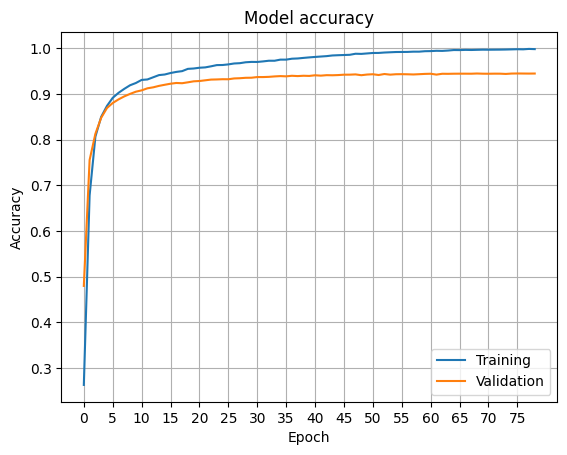

In [7]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.xticks(range(0, len(history.history['loss']), 5))
plt.grid()
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.xticks(range(0, len(history.history['loss']), 5))
plt.grid()
plt.show()

Evaluating on the test set gives a reassuring very high accuracy.

In [8]:
model.evaluate(x_test, y_test)
y_pred = model.predict(x_test)

313/313 [==============================] - 0s 353us/step


In [9]:
#model.save('mnist.h5')

## 1b) Attack your MNIST classifier with constant offsets

Add a constant perturbation to your test set images (e.g., c*torch.ones(28, 28)) and evaluate the performance as the magnitude increases. Also, be sure to clip your perturbed images so each pixel remains in [0, 1] (or [0, 255]).

**Deliverables**:
- Plot your test accuracy as a function of the perturbation magnitude
- Provide some examples where the un-perturbed image was labeled correctly and the perturbed image was labeled incorrectly, despite the perturbed image looking reasonable to a human.

I start by adding the constant noise to the original test set (not normalized). I then clip it to maximum 255 to keep that as an RGB image. Finally, I run the prediction after normalizing with the original max and min.

In [10]:
accuracy_list = []
for c in range(1, 51, 1): 
    x_test2 = x_test_orig + c * np.ones((28,28))
    x_test2 = np.clip(x_test2, None, 255)
    x_test2 = (x_test2 - min_train)/(max_train - min_train)
    result = model.evaluate(x_test2, y_test, verbose=0)
    accuracy_list.append(result[1])

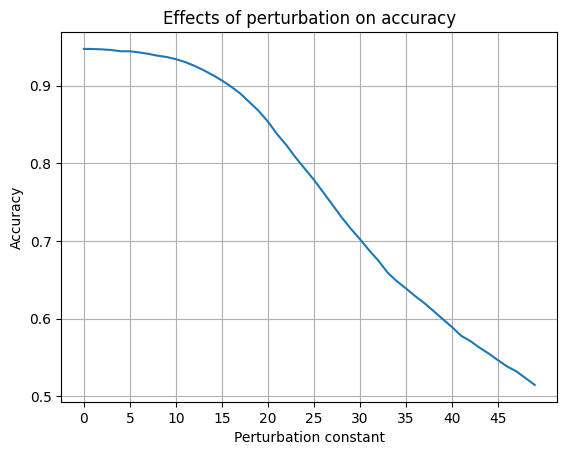

In [11]:
plt.xticks(range(0, len(accuracy_list), 5))
plt.title('Effects of perturbation on accuracy')
plt.xlabel("Perturbation constant")
plt.ylabel("Accuracy")
plt.grid()
plt.plot(accuracy_list)
plt.show()

In [20]:
def predict_value(min_, max_, X, model):
    return np.argmax(model.predict((X-min_)/(max_-min_), verbose=0), -1)

Original (real value):  [7]


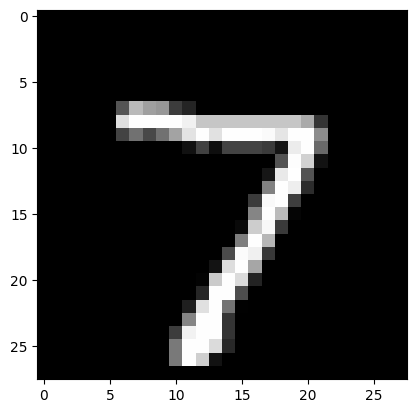

Adversarial value:  [2]


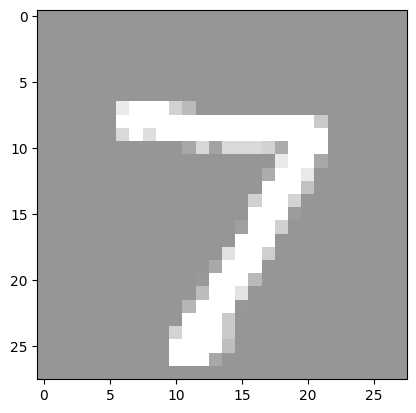

In [15]:
ex1 = np.clip(x_test_orig[0], 0, 255)
ex2 = np.clip(x_test_orig[0] + 150*np.ones((28,28)), 0, 255)

y_ex1 = predict_value(min_train, max_train, ex1, model)
y_ex2 = predict_value(min_train, max_train, ex2, model)

print("Original (real value): ", y_ex1)

plt.imshow(ex1,  cmap='gray', vmin=0, vmax=255)
plt.show()

print("Adversarial value: ", y_ex2)
plt.imshow(ex2,  cmap='gray', vmin=0, vmax=255)
plt.show()


## 1c) Attack your MNIST classifier with noise

Add some noise perturbations to your test set images and evaluate the performance as the noise magnitude increases. Also, be sure to clip your perturbed images so each pixel remains in [0, 1] (or [0, 255]).

**Deliverables**:
- Plot your test accuracy as a function of the perturbation magnitude
- A couple sentences about any differences observed with constant perturbations vs. noise perturbations

Since we are dealing with random noise, it is important to run the same experiment multiple times.

In [16]:
accuracy_list = []
for c in range(1, 51, 1):
    mean_exp = 0
    num_exp = 3
    for j in range(0, num_exp, 1):
        x_test3 = x_test_orig + np.random.randint(0, c, size=(28,28))
        x_test3 = np.clip(x_test3, 0, 255)
        x_test3 = (x_test3 - min_train)/(max_train - min_train)
        result = model.evaluate(x_test3, y_test, verbose=0)
        mean_exp += result[1]
    accuracy_list.append(mean_exp/num_exp)

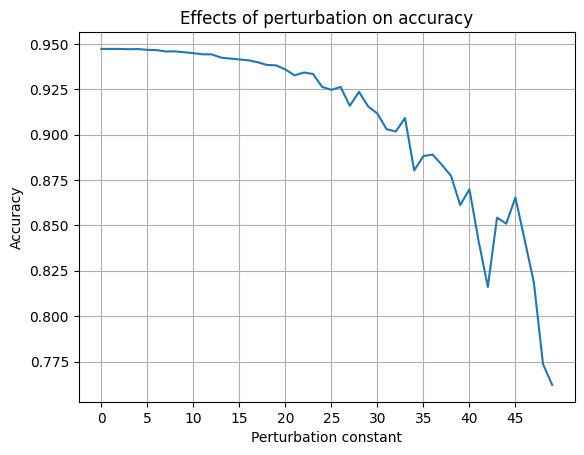

In [17]:
plt.xticks(range(0, len(accuracy_list), 5))
plt.title('Effects of perturbation on accuracy')
plt.xlabel("Perturbation constant")
plt.ylabel("Accuracy")
plt.grid()
plt.plot(accuracy_list)
plt.show()

Original (real value):  [0]


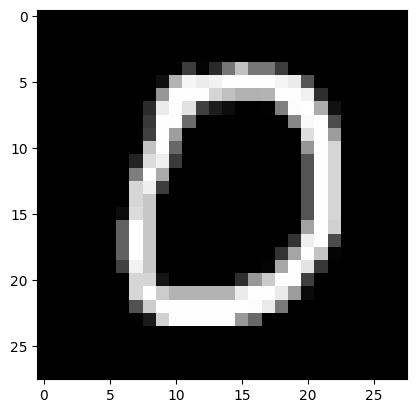

Adversarial value:  [2]


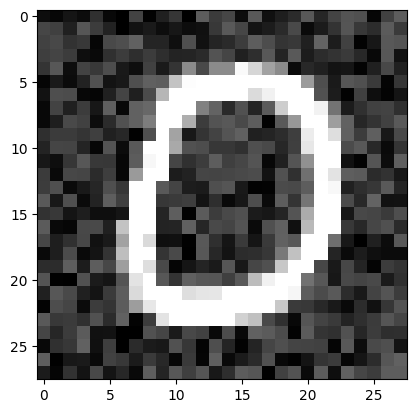

In [19]:
ex1 = np.clip(x_test_orig[10], 0, 255)
ex2 = np.clip(x_test_orig[10] + np.random.randint(0, 100, size=(28,28)), 0, 255)

y_ex1 = predict_value(min_train, max_train, ex1, model)
y_ex2 = predict_value(min_train, max_train, ex2, model)

print("Original (real value): ", y_ex1)

plt.imshow(ex1,  cmap='gray', vmin=0, vmax=255)
plt.show()

print("Adversarial value: ", y_ex2)
plt.imshow(ex2,  cmap='gray', vmin=0, vmax=255)
plt.show()


In addition to adding different random noise at each iteration, I try just to vary the amplitude of the noise that is constant. It is very similar to the first problem, but of course the matrix is not made of only ones.

In [20]:
accuracy_list = []
random_vector = np.random.rand(28,28)
for c in range(1, 51, 1):
    mean_exp = 0
    num_exp = 5
    for j in range(0, num_exp, 1):
        x_test3 = x_test_orig + c * random_vector
        x_test3 = np.clip(x_test3, 0, 255)
        x_test3 = (x_test3 - min_train)/(max_train - min_train)
        result = model.evaluate(x_test3, y_test, verbose=0)
        mean_exp += result[1]
    accuracy_list.append(mean_exp/num_exp)

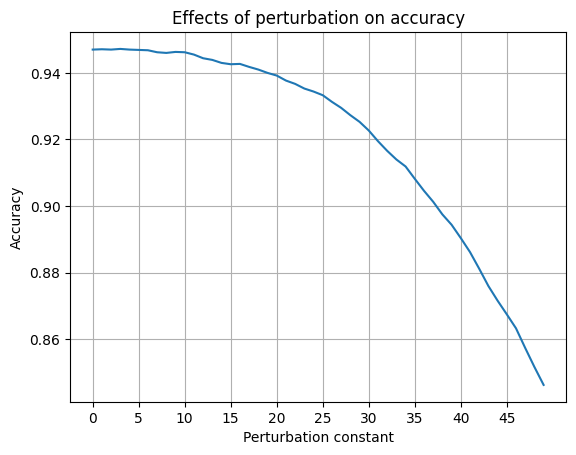

In [21]:
plt.xticks(range(0, len(accuracy_list), 5))
plt.title('Effects of perturbation on accuracy')
plt.xlabel("Perturbation constant")
plt.ylabel("Accuracy")
plt.grid()
plt.plot(accuracy_list)
plt.show()

Original (real value):  [9]


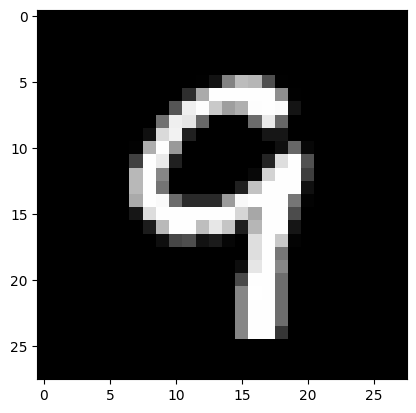

Adversarial value:  [2]


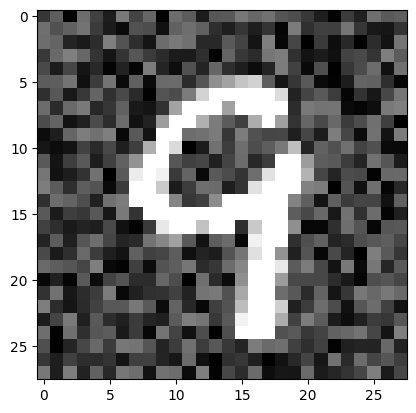

In [28]:
ex1 = np.clip(x_test_orig[150], 0, 255)
ex2 = np.clip(x_test_orig[150] +  np.random.randint(0, 128, size=(28,28)), 0, 255)

y_ex1 = predict_value(min_train, max_train, ex1, model)
y_ex2 = predict_value(min_train, max_train, ex2, model)

print("Original (real value): ", y_ex1)

plt.imshow(ex1,  cmap='gray', vmin=0, vmax=255)
plt.show()

print("Adversarial value: ", y_ex2)
plt.imshow(ex2,  cmap='gray', vmin=0, vmax=255)
plt.show()


Overall, we notice that the random noise perturbation leads to more oscillating results. In addition to 

## 1d) Attack your MNIST classifier with FGSM

Implement the Fast Gradient Sign Method (FGSM) attack algorithm and experiment with different values of $\epsilon$. You should write FGSM "from scratch" (e.g., using pytorch/numpy to evaluate the gradient, not using a library/method that already implements FGSM).

**Deliverables**:
- Plot your test accuracy as a function of the perturbation magnitude
- A couple sentences about how this curve compares to the constant perturbations and noise perturbations (hopefully, FGSM should be able to achieve lower test accuracy for the same attack magnitude as those model-agnostic attacks)

I start by implementing the FGSM attack. I use the automatic Tensorflow gradient tape to record the gradient in order to differentiate and get the sign of the gradient.

In [29]:
def fgsm_attack(image, real_labels, epsilon, min_train, max_train):
    adv_image = tf.Variable(image, dtype=tf.float32)
    image = tf.convert_to_tensor(image, dtype=tf.float32)
    with tf.GradientTape() as tape:
        tape.watch(image)
        prediction = model((image-min_train)/(max_train-min_train))
        loss = tf.losses.sparse_categorical_crossentropy(real_labels, prediction, from_logits=False)
    gradient = tape.gradient(loss, image)
    signed_grad = tf.sign(gradient)
    adv_image = image + 255 * epsilon * signed_grad # I am multiplying by 255 because the images are not scaled in the range [0,1]
    adv_image = tf.clip_by_value(adv_image, 0, 255)
    return adv_image

I try various combination of epsilon value.

In [30]:
accuracy_list = []
list_epsilon = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1]
for epsilon in list_epsilon:
    adv_image = fgsm_attack(x_test_orig, y_test_orig, epsilon, min_train, max_train)
    testing = (adv_image - min_train)/(max_train - min_train)
    result = model.evaluate(testing, y_test, verbose=1)
    accuracy_list.append(result[1])

313/313 [==============================] - 0s 390us/step - loss: 95.4928 - accuracy: 9.0000e-04


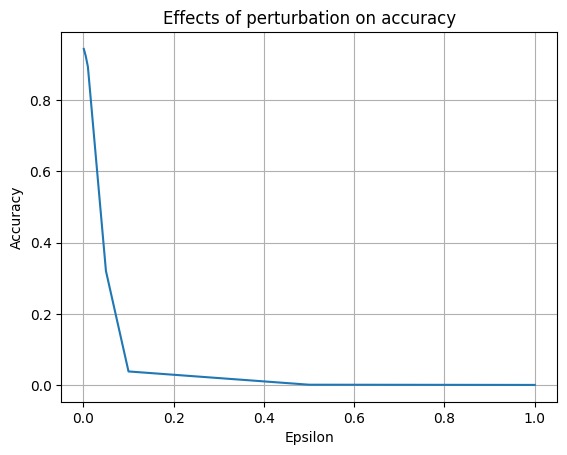

In [43]:
plt.title('Effects of perturbation on accuracy')
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.grid()
plt.plot(list_epsilon, accuracy_list)
plt.show()

Finally, I plot an example.

Original (real value):  [9]


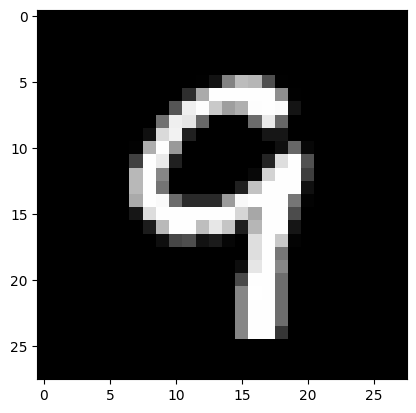

Adversarial value:  [4]


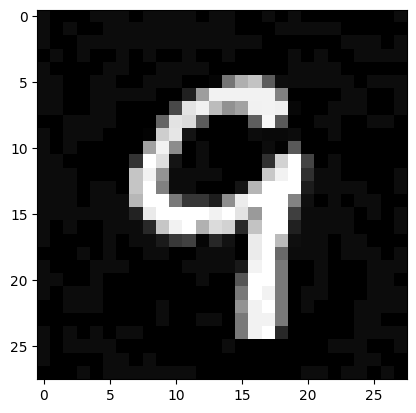

In [39]:
index = 150

ex1 = np.clip(x_test_orig[index], 0, 255)
ex2 = np.clip(fgsm_attack(x_test_orig[index:index+1], y_test_orig[index:index+1], 0.05, min_train, max_train), 0, 255)

y_ex1 = predict_value(min_train, max_train, ex1, model)
y_ex2 = predict_value(min_train, max_train, ex2, model)

print("Original (real value): ", y_ex1)

plt.imshow(ex1,  cmap='gray', vmin=0, vmax=255)
plt.show()

print("Adversarial value: ", y_ex2)
plt.imshow(np.reshape(ex2, (28,28)),  cmap='gray', vmin=0, vmax=255)
plt.show()


Interestingly, there is almost no difference in the image.

## 1e) Attack your MNIST classifier with Targeted FGSM

Implement the Targeted Fast Gradient Sign Method (TFGSM) attack algorithm and experiment with different values of $\epsilon$. You should write TFGSM "from scratch" (e.g., using pytorch/numpy to evaluate the gradient, not using a library/method that already implements TFGSM).

**Deliverables**:
- Plot your test accuracy as a function of the perturbation magnitude for each target class
- A few example images where you were able to successfully cause the classifier to predict the targeted (incorrect) class
- A few sentences about your model's susceptibility to targeted attacks (e.g., are some target classes "easier" to get your model to classify? if you try to perturb images labeled 0 to a target class of 8, does the image get perturbed in an intuitive way?)

For the targeted attack, it is important to notice that the loss function is negative.

In [5]:
model = tf.keras.models.load_model('mnist.h5')

In [6]:
def targeted_fgsm_attack(image, real_labels, epsilon, min_train, max_train, target_label):
    image_orig = tf.Variable(image, dtype=tf.float32)
    adv_image = tf.Variable(image, dtype=tf.float32)
    for i in range(20):
        with tf.GradientTape() as tape:
            tape.watch(adv_image)
            prediction = model((adv_image-min_train)/(max_train-min_train))
            loss = -tf.losses.sparse_categorical_crossentropy(target_label, prediction, from_logits=False)
        gradient = tape.gradient(loss, adv_image)
        signed_grad = tf.sign(gradient)
        adv_image = adv_image + 255*epsilon*signed_grad # I am multiplying by 255 because the images are not scaled in the range [0,1]
        adv_image = tf.clip_by_value(adv_image, 0, 255)
    return adv_image

The output of the following cell includes also how many digits are now the target one after the attack. With higher values of epsilon, almost all of them turn into the target digit.

In [16]:
accuracy_list_target = []
output_list = []
list_epsilon = [0.001, 0.005, 0.01, 0.05]
for i in range(0, 10, 1):
    accuracy_list_epsilon = []
    for epsilon in list_epsilon:
        print("Epsilon: ", epsilon, "; digit: ", i)
        adv_image = targeted_fgsm_attack(x_test_orig, y_test_orig, epsilon, min_train, max_train, target_label=i*np.ones(len(x_test_orig)))
        testing = (adv_image - min_train)/(max_train - min_train)
        #testing = adv_image
        result = model.predict(testing, verbose=0)#
        y_pred = np.argmax(result, -1)
        accuracy = np.sum(y_test_orig == y_pred)/len(y_test_orig)
        print("Accuracy: ", accuracy, end=";   ")
        print(len(y_pred[y_pred == i]), " over ", len(y_test_orig), " are now digit", i)
        accuracy_list_epsilon.append(accuracy)
    accuracy_list_target.append(accuracy_list_epsilon)
    print("")


Epsilon:  0.001 ; digit:  0
Accuracy:  0.9276;   1141  over  10000  are now digit 0
Epsilon:  0.005 ; digit:  0
Accuracy:  0.2633;   5356  over  10000  are now digit 0
Epsilon:  0.01 ; digit:  0
Accuracy:  0.1071;   9730  over  10000  are now digit 0
Epsilon:  0.05 ; digit:  0
Accuracy:  0.098;   10000  over  10000  are now digit 0

Epsilon:  0.001 ; digit:  1
Accuracy:  0.9298;   1267  over  10000  are now digit 1
Epsilon:  0.005 ; digit:  1
Accuracy:  0.2936;   6785  over  10000  are now digit 1
Epsilon:  0.01 ; digit:  1
Accuracy:  0.1151;   9758  over  10000  are now digit 1
Epsilon:  0.05 ; digit:  1
Accuracy:  0.1135;   10000  over  10000  are now digit 1

Epsilon:  0.001 ; digit:  2
Accuracy:  0.9148;   1364  over  10000  are now digit 2
Epsilon:  0.005 ; digit:  2
Accuracy:  0.1461;   9473  over  10000  are now digit 2
Epsilon:  0.01 ; digit:  2
Accuracy:  0.1037;   9990  over  10000  are now digit 2
Epsilon:  0.05 ; digit:  2
Accuracy:  0.1032;   10000  over  10000  are now di

Here I plot the accuracy wrt to epsilon, for all digits.

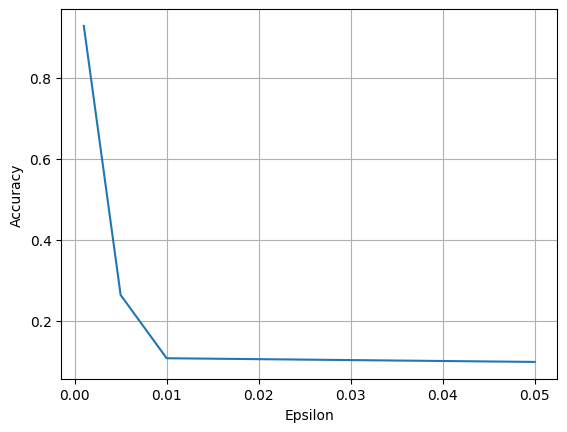

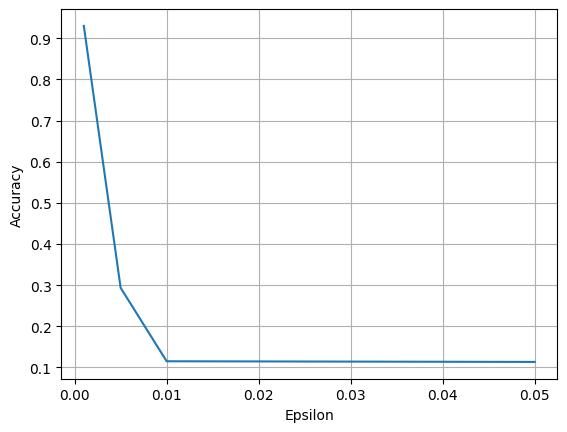

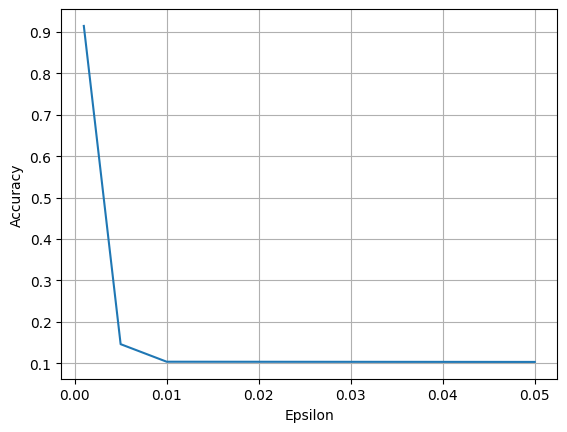

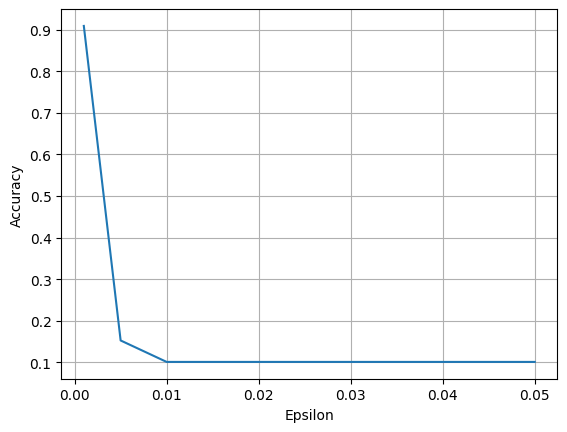

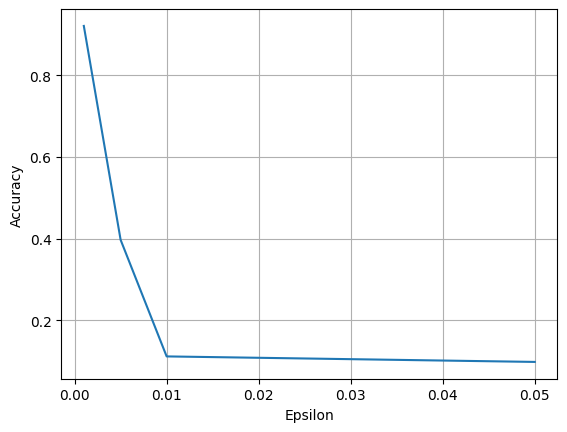

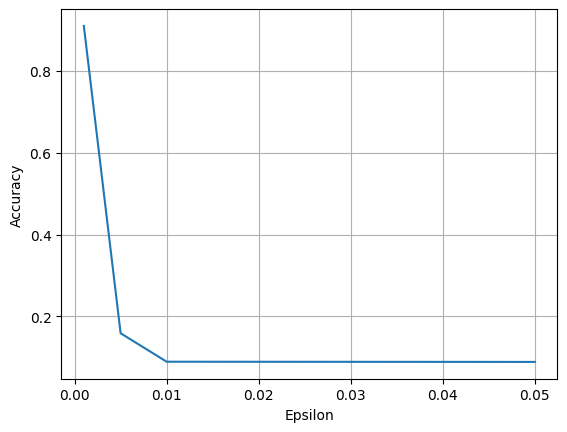

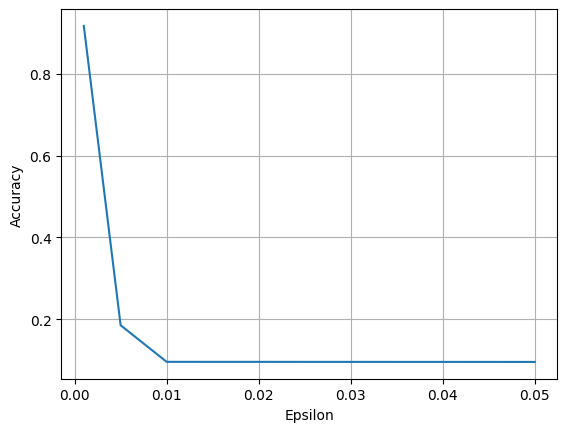

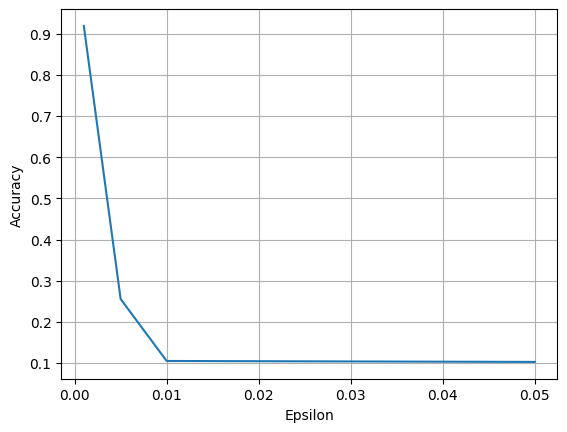

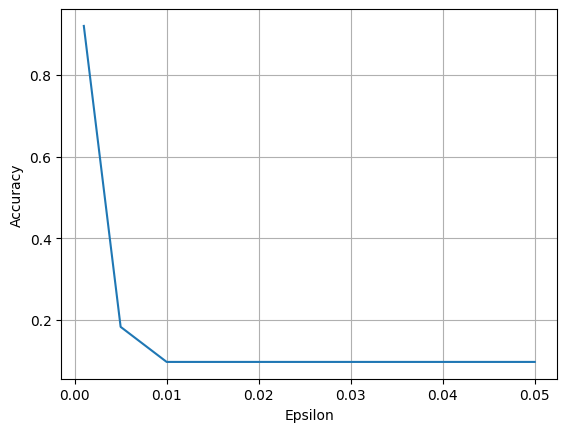

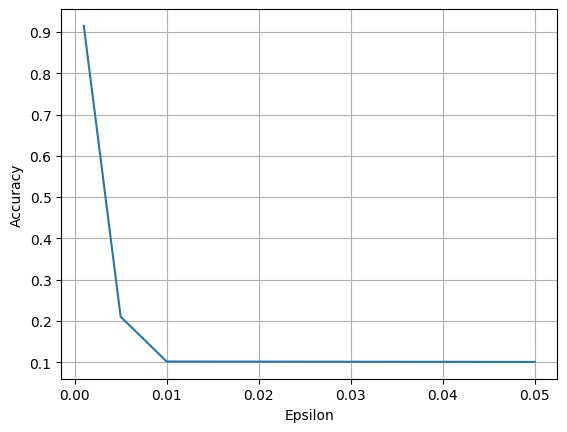

In [17]:
digit = 0
for l in accuracy_list_target:
    plt.plot(list_epsilon, l)
    plt.xlabel('Epsilon')
    plt.ylabel('Accuracy')
    #plt.title("Digit %i" %digit)
    plt.grid()
    plt.show()
    digit += 1

A couple of examples of the working system.

Original (real value):  [8]


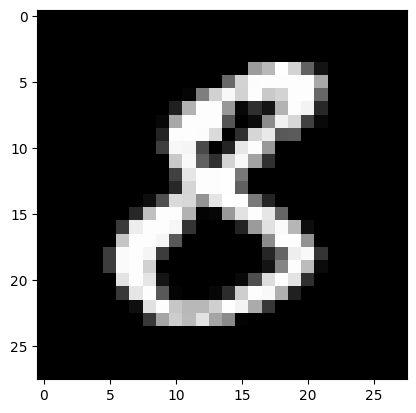

Adversarial attack value):  [6]


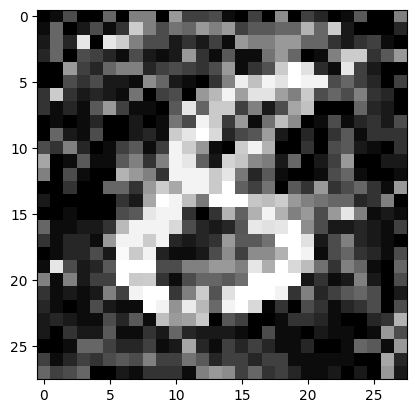





Original (real value):  [9]


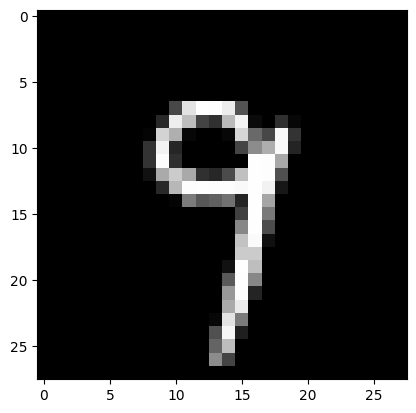

Adversarial attack value):  [1]


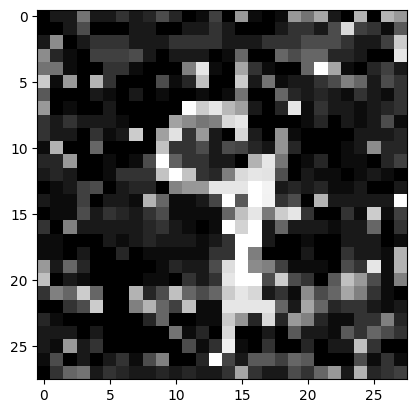

In [40]:
index = 1234
example = targeted_fgsm_attack(x_test_orig[index:index+1], y_test_orig[index:index+1], 0.05, min_train, max_train, 6)
#result = np.argmax(model.predict( (example-min_train)/(max_train-min_train)),-1)
y_ex1 = predict_value(min_train, max_train, x_test_orig[index:index+1], model)
y_ex2 = predict_value(min_train, max_train, example, model)
print("Original (real value): ", y_ex1)
plt.imshow(np.reshape(x_test_orig[index:index+1], (28,28)), cmap='gray', vmin=0, vmax=255)
plt.show()
print("Adversarial attack value): ", y_ex2)
plt.imshow(np.reshape(example, (28,28)), cmap='gray', vmin=0, vmax=255)
plt.show()
print("\n\n\n")

index = 2456
example = targeted_fgsm_attack(x_test_orig[index:index+1], y_test_orig[index:index+1], 0.05, min_train, max_train, 1)
#result = np.argmax(model.predict( (example-min_train)/(max_train-min_train)),-1)
y_ex1 = predict_value(min_train, max_train, x_test_orig[index:index+1], model)
y_ex2 = predict_value(min_train, max_train, example, model)
print("Original (real value): ", y_ex1)
plt.imshow(np.reshape(x_test_orig[index:index+1], (28,28)), cmap='gray', vmin=0, vmax=255)
plt.show()
print("Adversarial attack value): ", y_ex2)
plt.imshow(np.reshape(example, (28,28)), cmap='gray', vmin=0, vmax=255)
plt.show()

And, as requested, here is a clear example of a 0... turned into an 8!

Original (real value):  [0]


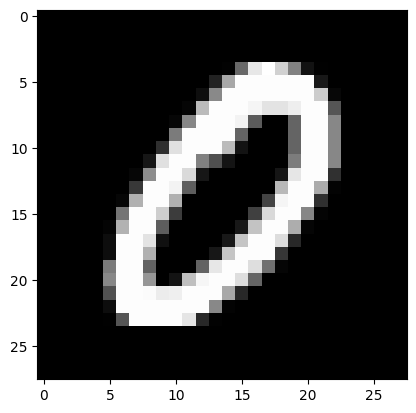

Adversarial attack value):  [8]


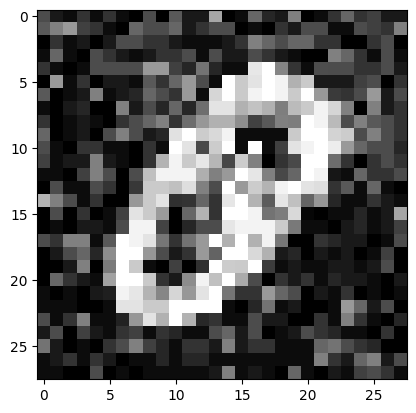

In [26]:
#indices = [i for i, x in enumerate(y_test_orig) if x == 0]

index = 9757
example = targeted_fgsm_attack(x_test_orig[index:index+1], y_test_orig[index:index+1], 0.05, min_train, max_train, 8)
#result = np.argmax(model.predict( (example-min_train)/(max_train-min_train)),-1)

y_ex1 = predict_value(min_train, max_train, x_test_orig[index:index+1], model)
y_ex2 = predict_value(min_train, max_train, example, model)

print("Original (real value): ", y_ex1)
plt.imshow(np.reshape(x_test_orig[index:index+1], (28,28)), cmap='gray', vmin=0, vmax=255)
plt.show()

print("Adversarial attack value): ", y_ex2)
plt.imshow(np.reshape(example, (28,28)), cmap='gray', vmin=0, vmax=255)
plt.show()

# Problem 2: Investigating Decision Boundaries

In this problem, you will train a binary classifier for a 2D input vector (is the (x, y) coordinate inside a circle of radius r centered at the origin?).

Since you will know the true decision boundary that the model is trained to approximate, you can generate training data.

Then, you will investigate the model's decision boundary to see how well it matches the true decision boundary.

## 2a) Generate training data

For $x\in R^2$, using the decision rule $f(x) = \begin{cases} 1, &\lvert\lvert x \rvert\rvert_2 \leq 3 \\ 0, & \text{o.w.} \end{cases}$, generate a training, validation, and test set of $[x, f(x)]$ pairs.

**Deliverables:**
- Plot your training set and the true decision boundary

In [75]:
# Define the number of data points
num_points = 5000

# Initialize empty arrays to store the data
data = []
labels = []

# Generate random points and assign labels
for _ in range(num_points):
    x = np.random.uniform(-2, 2)  # Random x-coordinate between -2 and 2
    y = np.random.uniform(-2, 2)  # Random y-coordinate between -2 and 2
    label = 1 if x**2 + y**2 <= 3 else 0  # Label 1 if inside the circle, else 0
    data.append([x, y])
    labels.append(label)

# Convert the lists to NumPy arrays
data = np.array(data)
labels = np.array(labels)

x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)
y_train = tf.one_hot(y_train.astype(np.int32), depth=2)
y_test = tf.one_hot(y_test.astype(np.int32), depth=2)

## 2b) Train NN classifier

Train a NN classifier on the data you just generated.

**Deliverables**:
- Plot your train & validation loss curves as a function of epoch

In [77]:
def create_model():
    model = tf.keras.Sequential()

    model.add(tf.keras.layers.Flatten(input_shape=(2,)))
    model.add(tf.keras.layers.Dense(16, activation='relu'))
    model.add(tf.keras.layers.Dense(2, activation='softmax'))
    loss = tf.keras.losses.CategoricalCrossentropy()
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=8e-4)
    
    metrics = ['accuracy']

    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    return model

In [78]:
model = create_model()
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_5 (Flatten)         (None, 2)                 0         
                                                                 
 dense_10 (Dense)            (None, 16)                48        
                                                                 
 dense_11 (Dense)            (None, 2)                 34        
                                                                 
Total params: 82
Trainable params: 82
Non-trainable params: 0
_________________________________________________________________


In [79]:
history = model.fit(x_train, y_train, validation_split = 0.85, epochs=50, callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1))

Epoch 1/50
19/19 [==============================] - 0s 6ms/step - loss: 0.8252 - accuracy: 0.4900 - val_loss: 0.7739 - val_accuracy: 0.4956
Epoch 2/50
19/19 [==============================] - 0s 2ms/step - loss: 0.7979 - accuracy: 0.4950 - val_loss: 0.7545 - val_accuracy: 0.5088
Epoch 3/50
19/19 [==============================] - 0s 3ms/step - loss: 0.7754 - accuracy: 0.5150 - val_loss: 0.7372 - val_accuracy: 0.5285
Epoch 4/50
19/19 [==============================] - 0s 3ms/step - loss: 0.7560 - accuracy: 0.5217 - val_loss: 0.7218 - val_accuracy: 0.5353
Epoch 5/50
19/19 [==============================] - 0s 2ms/step - loss: 0.7386 - accuracy: 0.5233 - val_loss: 0.7082 - val_accuracy: 0.5418
Epoch 6/50
19/19 [==============================] - 0s 3ms/step - loss: 0.7230 - accuracy: 0.5300 - val_loss: 0.6969 - val_accuracy: 0.5535
Epoch 7/50
19/19 [==============================] - 0s 2ms/step - loss: 0.7097 - accuracy: 0.5250 - val_loss: 0.6855 - val_accuracy: 0.5679
Epoch 8/50
19/19 [==

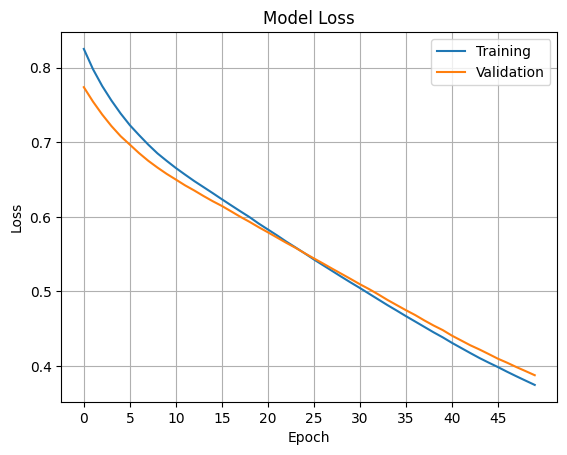

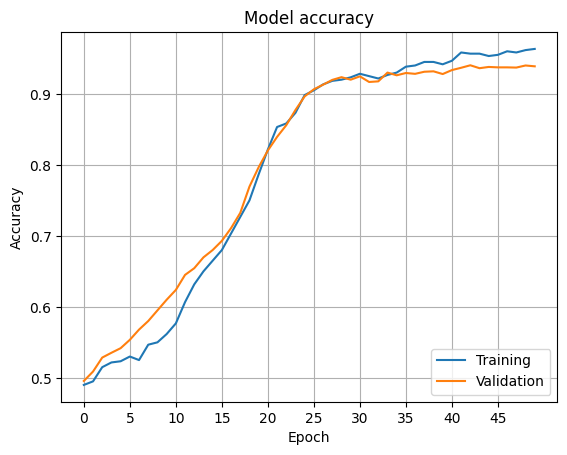

In [80]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.xticks(range(0, len(history.history['loss']), 5))
plt.grid()
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.xticks(range(0, len(history.history['loss']), 5))
plt.grid()
plt.show()

This is the score on the test dataset.

In [81]:
model.evaluate(x_test, y_test)

32/32 [==============================] - 0s 475us/step - loss: 0.3811 - accuracy: 0.9440


[0.38107043504714966, 0.9440000057220459]

## 2c) Compare decision boundaries

It is unlikely that your model has learned the true decision boundary perfectly. Here, you will investigate the differences.

**Deliverables**:
- Plot the true and learned decision boundaries
- A few sentences (with relevant figures to illustrate observations) about any differences and how changes to the model architecture or training procedure can impact decision boundaries (e.g., adding regularization, changing the training data generation method, changing the activation functions).

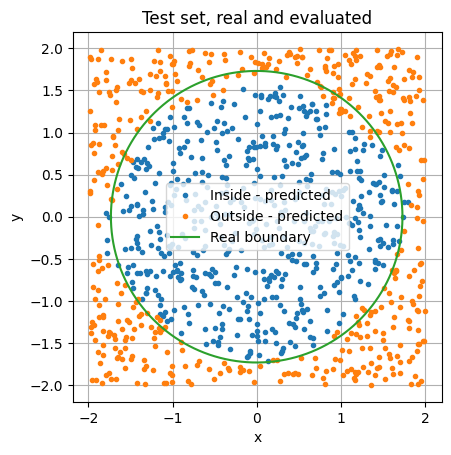

In [82]:
y_pred = model.predict(x_test, verbose=0)

x_target_inside = x_test[np.argmax(y_pred, -1) == 1]
x_target_outside = x_test[np.argmax(y_pred, -1) == 0]

# create a circle
radius = np.sqrt(3)
theta = np.linspace(0, 2*np.pi, 500)
x = radius * np.cos(theta)
y = radius * np.sin(theta)


plt.plot(x_target_inside[:, 0], x_target_inside[:, 1], '.')
plt.plot(x_target_outside[:, 0], x_target_outside[:, 1], '.')
plt.plot(x, y)
plt.axis('scaled')
plt.title('Test set, real and evaluated')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(['Inside - predicted', 'Outside - predicted', 'Real boundary'])
plt.grid()
plt.show()


Let's check the points on the actual border.

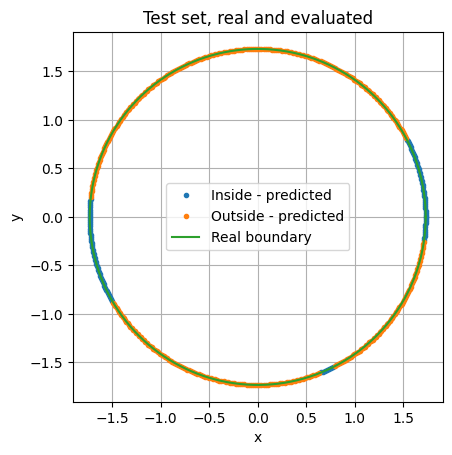

In [83]:
points = np.column_stack((x,y))

y_pred = model.predict(points, verbose=0)

x_target_inside = points[np.argmax(y_pred, -1) == 1]
x_target_outside = points[np.argmax(y_pred, -1) == 0]

plt.plot(x_target_inside[:, 0], x_target_inside[:, 1], '.')
plt.plot(x_target_outside[:, 0], x_target_outside[:, 1], '.')
plt.plot(x, y)
plt.axis('scaled')
plt.title('Test set, real and evaluated')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(['Inside - predicted', 'Outside - predicted', 'Real boundary'])
plt.grid()
plt.show()


As expected, the neural network is good but still not completely sure about points on the border. Further improvement could come from:

- using more data points, more specifically the one on the border;

- adding regularization techniques such as batch normalization;

For example: let's do fine tuning on a subset of (real) points from the borders.

In [84]:
labels = np.ones((len(points)))

In [85]:
x_train, x_test, y_train, y_test = train_test_split(points, labels, test_size=0.2, random_state=42)

In [86]:
y_train = tf.one_hot(y_train.astype(np.int32), depth=2)
y_test = tf.one_hot(y_test.astype(np.int32), depth=2)

In [90]:
model.fit(x_train, y_train, validation_split=0.2, epochs=20, callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1))

Epoch 1/20
10/10 [==============================] - 0s 5ms/step - loss: 0.4116 - accuracy: 1.0000 - val_loss: 0.3266 - val_accuracy: 1.0000
Epoch 2/20
10/10 [==============================] - 0s 2ms/step - loss: 0.2693 - accuracy: 1.0000 - val_loss: 0.2235 - val_accuracy: 1.0000
Epoch 3/20
10/10 [==============================] - 0s 2ms/step - loss: 0.1903 - accuracy: 1.0000 - val_loss: 0.1657 - val_accuracy: 1.0000
Epoch 4/20
10/10 [==============================] - 0s 2ms/step - loss: 0.1451 - accuracy: 1.0000 - val_loss: 0.1311 - val_accuracy: 1.0000
Epoch 5/20
10/10 [==============================] - 0s 2ms/step - loss: 0.1173 - accuracy: 1.0000 - val_loss: 0.1084 - val_accuracy: 1.0000
Epoch 6/20
10/10 [==============================] - 0s 2ms/step - loss: 0.0984 - accuracy: 1.0000 - val_loss: 0.0924 - val_accuracy: 1.0000
Epoch 7/20
10/10 [==============================] - 0s 3ms/step - loss: 0.0848 - accuracy: 1.0000 - val_loss: 0.0807 - val_accuracy: 1.0000
Epoch 8/20
10/10 [==

In [93]:
model.evaluate(x_test, y_test)

4/4 [==============================] - 0s 888us/step - loss: 0.0287 - accuracy: 1.0000


[0.028724730014801025, 1.0]

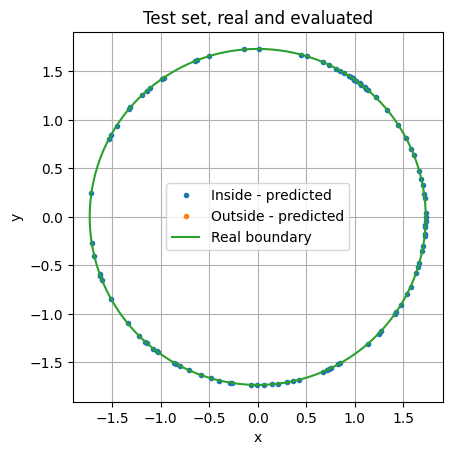

In [97]:
y_pred = model.predict(x_test, verbose=0)

x_target_inside = x_test[np.argmax(y_pred, -1) == 1]
x_target_outside = x_test[np.argmax(y_pred, -1) == 0]

plt.plot(x_target_inside[:, 0], x_target_inside[:, 1], '.')
plt.plot(x_target_outside[:, 0], x_target_outside[:, 1], '.')
plt.plot(x, y)
plt.axis('scaled')
plt.title('Test set, real and evaluated')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(['Inside - predicted', 'Outside - predicted', 'Real boundary'])
plt.grid()
plt.show()


# Problem 3: Attack Competition on a Pre-Trained CIFAR-10 Classifier [Extra Credit]

## 3.1 White-Box $l_\infty$-norm Attack

Here, you will have access to the full model (i.e., you know all of its parameters and architecture, you can compute gradients). You should write a function that takes in:
- the model
- a set of images + corresponding labels
- a perturbation magnitude,

and returns a perturbed version of the provided images that will cause the model to have poor classification accuracy.

We provide a template for your attack function and a function for checking the classification accuracy so that you can prototype locally. Once you upload your .ipynb to Gradescope (make sure it is named `hw1.ipynb`), we will run your attack function against some random test images and maintain a leaderboard of the strongest attack (we provide the actual evaluation script below for your convenience). Every student that gets the accuracy below 40% will get some extra credit, and the student with strongest attack will get more extra credit. In case of a tie, we will look at runtime. You can keep updating your submission until the deadline.

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import time
import torch
import torch.nn as nn
import torch.optim as optim

Here's a suggested way of getting the CIFAR-10 dataset:

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
batch_size = 256

transform = transforms.Compose([transforms.ToTensor()])

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2,
                                         pin_memory=True)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


Here's the model you'll be attacking (ResNet20):

In [3]:
model = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar10_resnet20", pretrained=True)

/usr/local/lib/python3.9/dist-packages/torch/hub.py:266: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/chenyaofo/pytorch-cifar-models/zipball/master" to /root/.cache/torch/hub/master.zip
Downloading: "https://github.com/chenyaofo/pytorch-cifar-models/releases/download/resnet/cifar10_resnet20-4118986f.pt" to /root/.cache/torch/hub/checkpoints/cifar10_resnet20-4118986f.pt


  0%|          | 0.00/1.09M [00:00<?, ?B/s]

While CIFAR-10 images have pixel values $\in [0, 1]$, the model we're attacking was trained on a normalized version of CIFAR-10 (i.e., each image was shifted/scaled by a mean/std). You can attack the model in the original pixel coordinates (that's the space we'll enforce the attack magnitude), but remember that any time you want to query the model, you should first normalize the images according to those settings:

In [4]:
def normalize(imgs):
  mean = (0.4914, 0.4822, 0.4465)
  std = (0.2023, 0.1994, 0.2010)
  Normalize = transforms.Normalize(mean=mean, std=std)
  return Normalize(imgs)

This function may help you when familiarizing yourself with the dataset and baseline model performance (and shows an example of using the normalize function right before querying the model):

In [133]:
def quickly_run_model(model, testloader, num_to_show=4):
  dataiter = iter(testloader)

  # `images` coming out of the dataloader are tensors of size (batch, 3, 32, 32)
  # where each pixel is within [0, 1].
  images, labels = next(dataiter)

  model = model.to(device)
  images = images.to(device)
  labels = labels.to(device)

  # The model was trained on a normalized version of the dataset
  # (i.e., each pixel was scaled/shifted by mean and std).
  # ==> we will normalize our images in that same way before querying model
  normalized_images = normalize(images)
  outputs = model(normalized_images)
  _, predicted = torch.max(outputs, 1)
  print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                                for j in range(num_to_show)))
  print('Labels: ', ' '.join(f'{classes[labels[j]]:5s}'
                                for j in range(num_to_show)))

quickly_run_model(model, testloader)

Predicted:  cat   ship  ship  plane
Labels:  cat   ship  ship  plane


The function you will fill in is `white_box_attack`. The autograder expects this exact function name and signature, so make sure those stay the same:

I use a basic implementation of a PGD attack, as described in the paper. I would like to underline the following interesting behaviour:

- alpha: I found out that the best value in my approach is to set it to the same as the attack_magnitude (1./255 ~ 0.0392). It makes sense, since it would correspond to a single unit of difference in an RGB image (where values are between 0 and 255);

- attack_magnitude: I am using the value of the homework, it has a direct effect since it is the value to which the difference of the images are clipped;

- differentiability and gradient in Pytorch: I am not an expert in Pytorch (I have always used Tensorflow), but it seems that to get a good result I need to detatch the tensor "perturbed_image" after calculating the gradient, and use the syntax "a += bx" instead of "a = a + bx" to add the disturbance to the image. It may be because in the first case I am just adding a value whereas in the second I am creating a new tensor (with maybe a different gradient?);

- number of iterations: I tried a bunch of them, and 5 seems to be fast and (non)accurate.

In [5]:
def white_box_attack(model, raw_images, labels, attack_magnitude):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    raw_images.to(device)
    perturbed_images = raw_images
    labels = labels.to(device)
    loss = nn.CrossEntropyLoss()
    original_images = perturbed_images.data
    
    alpha = attack_magnitude
    iters = 3
    
    for i in range(iters) : 
        model.zero_grad()

        perturbed_images.requires_grad = True
        
        outputs = model(normalize(perturbed_images))
        cost = loss(outputs, labels).to(device)
        cost.backward()
        
        sign_gradient = perturbed_images.grad.sign()
        perturbed_images.detach_()
        
        perturbed_images += alpha*sign_gradient

        difference = torch.clip(perturbed_images - original_images, min=-attack_magnitude, max=attack_magnitude)
        perturbed_images = torch.clip(original_images + difference, min=0, max=1)
    return perturbed_images


To help you debug, here's the function we will use to evaluate your `white_box_attack`. This should give 92.6% accuracy when there is no attack. This function is meant to be able to run standalone (i.e., not in a Jupyter notebook where the model/dataset may already be loaded), so feel free to modify it to be more efficient when debugging. We will run your attack against our own replica of this function on Gradescope's servers, so the runtime numbers will likely differ from what you observe locally or on Colab:

In [6]:
def evaluate_attacked_accuracy(attack_magnitude, attack_fn=white_box_attack, device="cpu"):

  # We will run your attack against this function to establish the leaderboard

  testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform)
  testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                          shuffle=False, num_workers=2,
                                          pin_memory=True)

  model = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar10_resnet20", pretrained=True)

  attack_runtime = 0.
  correct = 0
  total = 0
  model.to(device)
  model.eval()
  for raw_images, labels in testloader:

    raw_images = raw_images.to(device)
    labels = labels.to(device)

    attack_runtime_start = time.time()
    perturbed_images = attack_fn(model, raw_images, labels, attack_magnitude)
    attack_runtime_end = time.time()
    attack_runtime += attack_runtime_end - attack_runtime_start

    assert torch.all(perturbed_images <= 1.) and torch.all(perturbed_images >= 0.), "Perturbed images contain pixels outside of [0, 1]."
    print("Diff max: ", (torch.linalg.vector_norm(perturbed_images - raw_images, ord=torch.inf, dim=(1,2,3))).max(), "diff mean: ", (torch.linalg.vector_norm(perturbed_images - raw_images, ord=torch.inf, dim=(1,2,3))).mean(), " ok would be: ", attack_magnitude + 1e-6)
    assert torch.all(torch.linalg.vector_norm(perturbed_images - raw_images, ord=torch.inf, dim=(1,2,3)) <= attack_magnitude + 1e-6), "Perturbation violates attack magnitude limit."

    # calculate outputs by running images through the network
    with torch.no_grad():
      normalized_perturbed_images = normalize(perturbed_images)
      outputs = model(normalized_perturbed_images)

    # the class with the highest energy is what we choose as prediction
    _, predicted = torch.max(outputs.data, 1)

    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    print(100 * correct / total)

  accuracy = 100 * correct / total

  return accuracy, attack_runtime, perturbed_images

You can run the above evaluation function as follows:

In [7]:
# We will enforce that the l_inf norm of the perturbation is <= attack_magnitude
attack_magnitude = 1./255
accuracy, attack_runtime, perturbed_images = evaluate_attacked_accuracy(attack_magnitude)
print(f"Accuracy: {accuracy} %")
print(f"Attack Runtime: {attack_runtime} [s]")

Files already downloaded and verified


Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Diff max:  tensor(0.0039, device='cuda:0') diff mean:  tensor(0.0039, device='cuda:0')  ok would be:  0.0039225686274509805
3.125
Diff max:  tensor(0.0039, device='cuda:0') diff mean:  tensor(0.0039, device='cuda:0')  ok would be:  0.0039225686274509805
4.1015625
Diff max:  tensor(0.0039, device='cuda:0') diff mean:  tensor(0.0039, device='cuda:0')  ok would be:  0.0039225686274509805
3.6458333333333335
Diff max:  tensor(0.0039, device='cuda:0') diff mean:  tensor(0.0039, device='cuda:0')  ok would be:  0.0039225686274509805
4.1015625
Diff max:  tensor(0.0039, device='cuda:0') diff mean:  tensor(0.0039, device='cuda:0')  ok would be:  0.0039225686274509805
4.375
Diff max:  tensor(0.0039, device='cuda:0') diff mean:  tensor(0.0039, device='cuda:0')  ok would be:  0.0039225686274509805
4.622395833333333
Diff max:  tensor(0.0039, device='cuda:0') diff mean:  tensor(0.0039, device='cuda:0')  ok would be:  0.0039225686274509805
4.352678571428571
Diff max:  tensor(0.0039, device='cuda:0') di

Note: the attack above was run with 5 iterations. Only 3 are used on Gradescope because of time constraints.